In [2]:
from hacktops.model import TopFinder
from tslearn.metrics import dtw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hacktops.data import generate_top_dataset
from sklearn.model_selection import StratifiedShuffleSplit
from hacktops.utils import instance_norm

In [3]:
top_ = 'CONRAD'
df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")

dataset = generate_top_dataset(df_logs=df_logs_, df_tops=df_tops_, top=top_)

NAN FOUND
NAN FOUND
NAN FOUND
NAN FOUND


In [4]:
X = np.array(dataset[0]).squeeze(axis=2)
y = np.array(dataset[1])

X = np.array([instance_norm(x) for x in X])
    
print('X:', X.shape)
print('y:', y.shape)

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_index, test_index = next(sss.split(X, y))
test_true_idx = [idx for idx in test_index if y[idx] == True]
train_true_idx = [idx for idx in train_index if y[idx] == True]
test_false_idx = [idx for idx in test_index if y[idx] == False]
train_false_idx = [idx for idx in train_index if y[idx] == False]

print('train_true_idx num:', len(train_true_idx))
print('test samples num:', len(test_index))

X: (119196, 61)
y: (119196,)
train_true_idx num: 8046
test samples num: 11920


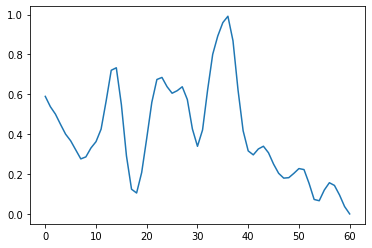

In [5]:
plt.plot(X[1])

In [39]:
class MyKNN:
    def __init__(self, n_neighbors=5, metric=dtw):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X):
        self._X = X

    def predict_proba(self, X):
        res = []
        for x in X:
            dists = np.array([self.metric(_x, x) for _x in self._X])
            weights = 1/(1+dists)
            res.append(weights.sum()/weights.shape[0])
        return res

neigh = MyKNN(n_neighbors=5, metric=dtw)
neigh.fit(X[train_true_idx])

top_finder = TopFinder(neigh, top_)
neigh.evaluate_windows = neigh.predict_proba
top_finder.examine_dataset(df_tops_)

In [7]:
# test on all true samples
print('test_true_idx num:', len(test_true_idx))
test_true_res = neigh.predict_proba(X[test_true_idx])

test_true_idx num: 894


In [8]:
# test on 1000 false samples
test_false_res = neigh.predict_proba(X[test_false_idx[:1000]])

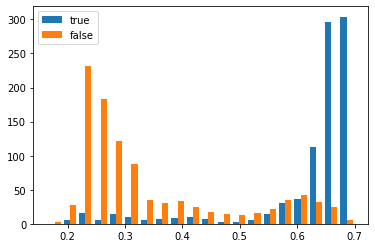

In [24]:
plt.hist([test_true_res,test_false_res], label=['true', 'false'], bins=20)
plt.legend(loc='upper left')


In [34]:
split_point = 0.60
TP = len([score for score in test_true_res if score > split_point])
TN = len([score for score in test_false_res if score < split_point])
FP = len([score for score in test_false_res if score > split_point])
FN = len([score for score in test_true_res if score < split_point])
print(f'TP {TP} | TN {TN} | FP {FP} | FN {FN}')
print(f'acc: {(TP+TN)/(TP+TN+FP+FN)}')

TP 739 | TN 911 | FP 89 | FN 155
acc: 0.8711721224920802


1512
6556.0


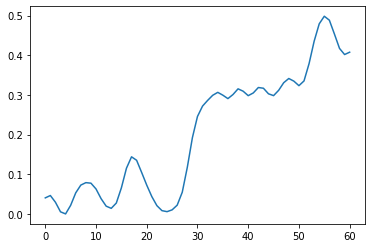

In [35]:
well_name = df_tops_.index[60]
df_well = df_logs_[df_logs_['wellName'] == well_name]
windows = top_finder.get_candidate_windows(df_well)

windows = [(w[0], np.array(instance_norm(w[1]))) for w in windows]

windows_depth = np.array([w[0] for w in windows])
windows_data = np.array([w[1] for w in windows])

print(len(windows))

true_depth = df_tops_.loc[well_name,top_]
print(true_depth)

true_window = [w for w in windows if w[0]==true_depth][0]
plt.plot(instance_norm(true_window[1]))


In [36]:
match = [w for w in X[train_true_idx+test_true_idx] if np.array_equal(w, true_window[1])]
if len(match) == 1:
    print('check data correctness: pass')

check data correctness: pass


In [37]:
close_windows = [w for w in windows if abs(w[0]-true_depth) < 50]
print(len(close_windows))
close_windows_depth = np.array([w[0] for w in close_windows])
close_windows_data = np.array([w[1] for w in close_windows])

199


In [40]:
res = neigh.predict_proba(close_windows_data)

0.6952089452190993


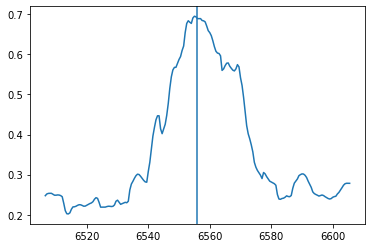

In [41]:
print(max(res))
plt.plot(close_windows_depth, res)
plt.axvline(true_depth)

In [42]:
# now test on the whole well
res1 = neigh.predict_proba(windows_data)

In [51]:
max_idx = res1.index(max(res1))
max_score_depth = windows_depth[max_idx]
print('true depth:', true_depth)
print('max score depth:', max_score_depth)

true depth: 6556.0
max score depth: 6555.0


In [52]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
data = []
data.append(go.Scatter(x=windows_depth,y=res1))
fig = go.Figure(data=data)
fig.add_vline(x=true_depth, line_width=2, line_color="green")
fig.add_vline(x=max_score_depth, line_width=2, line_color="yellow")
iplot(fig)

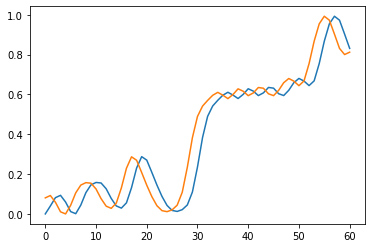

In [54]:
plt.plot(windows_data[max_idx])
plt.plot(true_window[1])